# Importing the Data and The Libraries
#### This Notebook was created for Using a Classification Approach Towards Predicting Relative Humidity without Dew Point

In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import decomposition
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.decomposition import TruncatedSVD, FastICA, NMF, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV


from sklearn.manifold import TSNE

from sklearn.decomposition import KernelPCA, PCA

df = pd.read_csv("HumidityDataset.csv")

C:\Users\sherwin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning:

Columns (1,2,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.



## Dropping all the libraires and selecting only rows that start after the 2010

In [2]:
df.drop(["longitude","latitude", "WaveHeight", "WavePeriod", "MeanWaveDirection","Hmax","QC_Flag"],inplace = True, axis = 1)
df = df.iloc[331371:]
buoy_ident = { 'M2':1 , 'M3': 2, 'M4':3, 'M5': 4, 'M6': 5}
# df.station_id.nunique()


## Outliers i.e values velow 60 were removed and 18 bins were created for classification 

In [3]:
df = df.loc[df['RelativeHumidity']>60]
df['StratHumidity'] = pd.cut(df.RelativeHumidity, bins=18, labels=np.arange(18), right=False)

##### droppig unnecessary Values

In [4]:
# Selecting only the values of rows that have buoys ident as M2 to M6
df = df.loc[df.station_id.isin(buoy_ident.keys()) ]
df = df.drop(["time"], axis = 1)
# df.station_id.unique()

In [5]:
df = df.replace({ 'station_id': buoy_ident})
df = df.dropna(axis = 1, how='all')
df.reset_index(inplace = True)
df.dropna(inplace = True, how = 'all')
df.head()

,index,station_id,AtmosphericPressure,WindDirection,WindSpeed,Gust,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity,StratHumidity
0,331371,1,1007.2,50,17,25,5.5,-1.1,10.3,62,0
1,331372,5,1015.8,20,18,33,7,0.9,11.4,65,2
2,331373,4,1006.2,NaN,NaN,NaN,5.3,1.7,10.6,78,8
3,331374,3,1011.2,10,12,20,4.7,1.1,10.2,78,8
4,331375,2,1009.4,30,17,25,5.7,-1.2,10.4,61,0


In [6]:
df = df.apply(pd.to_numeric)
df = df.dropna()
df.drop('index', axis = 1, inplace = True)
df_vis = df.copy()
df_vis = df_vis.apply(pd.to_numeric)

# Selecting only the top 2 most correlated with the Dependent Variable

In [7]:
df = df[['AirTemperature','SeaTemperature','StratHumidity']]
df.head()
df = df.dropna()
# df.reset_index(inplace= True)
# df.isna()
# drop('index',axis = 1, inplace = True)

In [8]:
df.shape

(83581, 3)

## Custom Scaler Code for ease of Scaling Y and X values separately 

In [11]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df.iloc[:,:-1].values,df.iloc[:,-1].values, test_size=0.2)
print(X_train1.shape)

class CustomScaler():
    
        def __init__(self, X_Scale, y_Scale ) :
        
            self.X_Scale =   X_Scale 
            self.y_Scale =   y_Scale
            
            self.x_num =     [np.min(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            self.x_maxs =    [np.max(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            self.x_mins =    [np.min(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            
            self.y_num =     np.min(self.y_Scale)
            self.y_max_min = np.max(self.y_Scale) - np.min(self.y_Scale)

        def scaleX(self, x_value):
            x = x_value.copy()
            for i in range(x.shape[1]):
                
                x[:,i]= (x[:,i] - self.x_num[i])/(self.x_maxs[i]-self.x_mins[i])
            return x

        def inverseScaleX(self, x_value):
            x = x_value.copy()
            
            for i in range(x.shape[1]):
                x[:,i]= (x[:,i] * (self.x_maxs[i]-self.x_mins[i])) + self.x_num[i]
            return x



        

        def scaleY(self, y_value):
            y = y_value.copy()
            ys = (y - self.y_num)/(self.y_max_min)
            return ys

        def inverseScaleY(self, y_value):
            y = y_value.copy()
            ys = (y * self.y_max_min) + self.y_num
            return ys


        



custom_scaler = CustomScaler(X_train1,y_train1)
    
X_train = custom_scaler.scaleX(X_train1.copy())
# y_train = custom_scaler.scaleY(y_train1.copy())
transform = None


print(X_train[-70000: -1])

print(X_test1[:10,:],y_test1[:10])



(66864, 2)
[[0.52840909 0.30275229]
 [0.73295455 0.53211009]
 [0.25       0.25688073]
 ...
 [0.63636364 0.40366972]
 [0.03977273 0.02752294]
 [0.72159091 0.51376147]]
[[10.4 11. ]
 [10.2 10.7]
 [ 3.  10.6]
 [12.4 13.8]
 [15.1 14.8]
 [10.9 11.7]
 [12.2 13.8]
 [15.8 15.4]
 [16.3 16.5]
 [ 7.8  9.9]] [13  4 13 12  7 14  6 15 13 10]


## Code for different Feature Extraction Methods Which was Finally Scrapped 

In [12]:
# # transformer = KernelPCA(0.95, kernel='linear').fit(X_train)
# # transformer = PCA(0.99).fit(X_train)
# transformer = decomposition.TruncatedSVD(n_components=7, algorithm='arpack').fit(X_train)

# X_train = transformer.transform(X_train)
# print(X_train)

# transformer = TruncatedSVD(6).fit(X_train)
# X_train = transformer.transform(X_train)
# X_train

# transformer = FastICA(6).fit(X_train)
# X_train = transformer.transform(X_train)
# X_train



# This is not working for some reason needs to be fixed 
# transformer = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(np.asarray(X_train).astype(float),y_train)
# X_train = transformer.transform(X_train)
transformer = None

In [13]:

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## One Hot Encoding of the Features for Classification 

In [14]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


X_train = np.asarray(X_train).astype('float32')
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train1)


In [15]:
y_train.shape

(66864, 18)

## Keras Based Classification Model 

In [16]:

def model1():    
    model = keras.Sequential()
    model.add(Dense(20, activation = "relu",input_dim = X_train.shape[1], name = "layer1"))
    model.add(Dense(50, activation = "relu", name = "layer2"))
    model.add(Dense(50, activation = "relu", name = "layer6"))

    model.add(Dense(18, activation='softmax', name = "layer7"))
    model.compile(loss='categorical_crossentropy', optimizer='adamax',metrics=['accuracy'])
    return model

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

estimator = KerasClassifier(build_fn=model1, epochs=1000, batch_size=1024, verbose=1)
history=estimator.fit(X_train, y_train)


Epoch 1/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.8375 - accuracy: 0.0962
Epoch 2/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.7941 - accuracy: 0.1007
Epoch 3/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.7838 - accuracy: 0.1063
Epoch 4/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.7708 - accuracy: 0.1192
Epoch 5/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.7501 - accuracy: 0.1275
Epoch 6/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.7191 - accuracy: 0.1282
Epoch 7/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.6813 - accuracy: 0.1332
Epoch 8/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.6465 - accuracy: 0.1333
Epoch 9/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.6211 - accuracy: 0.1344
Epoch 10/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.6055 - accuracy: 0.1344

66/66 [==============================] - 0s 2ms/step - loss: 2.5642 - accuracy: 0.1439
Epoch 163/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5641 - accuracy: 0.1442
Epoch 164/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5641 - accuracy: 0.1438
Epoch 165/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5642 - accuracy: 0.1447
Epoch 166/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5645 - accuracy: 0.1439
Epoch 167/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5641 - accuracy: 0.1445
Epoch 168/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5640 - accuracy: 0.1437
Epoch 169/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5638 - accuracy: 0.1444
Epoch 170/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5639 - accuracy: 0.1442
Epoch 171/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5643 - accuracy: 0.

66/66 [==============================] - 0s 2ms/step - loss: 2.5613 - accuracy: 0.1461
Epoch 323/1000
66/66 [==============================] - 0s 3ms/step - loss: 2.5608 - accuracy: 0.1460
Epoch 324/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5610 - accuracy: 0.1450
Epoch 325/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5610 - accuracy: 0.1450
Epoch 326/1000
66/66 [==============================] - 0s 3ms/step - loss: 2.5609 - accuracy: 0.1447
Epoch 327/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5610 - accuracy: 0.1448
Epoch 328/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5610 - accuracy: 0.1455
Epoch 329/1000
66/66 [==============================] - 0s 3ms/step - loss: 2.5609 - accuracy: 0.1450
Epoch 330/1000
66/66 [==============================] - 0s 3ms/step - loss: 2.5608 - accuracy: 0.1453
Epoch 331/1000
66/66 [==============================] - 0s 3ms/step - loss: 2.5608 - accuracy: 0.

66/66 [==============================] - 0s 2ms/step - loss: 2.5587 - accuracy: 0.1459
Epoch 483/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5589 - accuracy: 0.1454
Epoch 484/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5584 - accuracy: 0.1467
Epoch 485/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5588 - accuracy: 0.1451
Epoch 486/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5583 - accuracy: 0.1459
Epoch 487/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5583 - accuracy: 0.1461
Epoch 488/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5585 - accuracy: 0.1452
Epoch 489/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5583 - accuracy: 0.1457
Epoch 490/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5583 - accuracy: 0.1464
Epoch 491/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5585 - accuracy: 0.

66/66 [==============================] - 0s 2ms/step - loss: 2.5560 - accuracy: 0.1469
Epoch 643/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5561 - accuracy: 0.1462
Epoch 644/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5561 - accuracy: 0.1467
Epoch 645/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5561 - accuracy: 0.1462
Epoch 646/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5562 - accuracy: 0.1473
Epoch 647/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5564 - accuracy: 0.1461
Epoch 648/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5559 - accuracy: 0.1467
Epoch 649/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5561 - accuracy: 0.1468
Epoch 650/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5561 - accuracy: 0.1463
Epoch 651/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5561 - accuracy: 0.

66/66 [==============================] - 0s 2ms/step - loss: 2.5542 - accuracy: 0.1468
Epoch 803/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5541 - accuracy: 0.1482
Epoch 804/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5541 - accuracy: 0.1475
Epoch 805/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5542 - accuracy: 0.1476
Epoch 806/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5542 - accuracy: 0.1474
Epoch 807/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5538 - accuracy: 0.1488
Epoch 808/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5542 - accuracy: 0.1475
Epoch 809/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5542 - accuracy: 0.1478
Epoch 810/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5539 - accuracy: 0.1473
Epoch 811/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5543 - accuracy: 0.

66/66 [==============================] - 0s 2ms/step - loss: 2.5523 - accuracy: 0.1490
Epoch 963/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5525 - accuracy: 0.1478
Epoch 964/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5522 - accuracy: 0.1486
Epoch 965/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5523 - accuracy: 0.1483
Epoch 966/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5524 - accuracy: 0.1478
Epoch 967/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5523 - accuracy: 0.1480
Epoch 968/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5522 - accuracy: 0.1483
Epoch 969/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5523 - accuracy: 0.1485
Epoch 970/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5527 - accuracy: 0.1492
Epoch 971/1000
66/66 [==============================] - 0s 2ms/step - loss: 2.5524 - accuracy: 0.

## lotting the Model history 

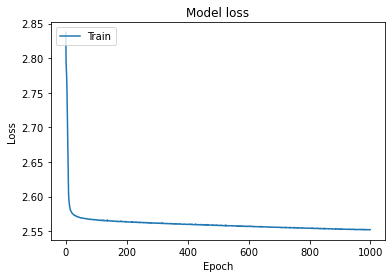

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluation of the model and Comparison at the end 

In [19]:
from sklearn.metrics import accuracy_score

y_pred = estimator.predict(custom_scaler.scaleX(X_test1))
accuracy_score(y_test1,y_pred )

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
17/17 [==============================] - 0s 1ms/step


0.1524795118741401

In [20]:
np.column_stack((y_test1,y_pred))

array([[13,  8],
       [ 4,  8],
       [13,  8],
       ...,
       [ 1,  4],
       [11, 16],
       [ 8,  8]], dtype=int64)

In [ ]:
from sklearn.metrics import confusion_matrix
